## Netdata Anomaly Detection Deepdive

<a href=\"https://colab.research.google.com/github/netdata/community/blob/main/netdata-agent-api/netdata-pandas/anomalies_collector_deepdive.ipynb\" target=\"_blank\"><img src=\"https://colab.research.google.com/assets/colab-badge.svg\" alt=\"Open In Colab\"/></a>

In [94]:
#!pip install netdata-pandas

In [95]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from netdata_pandas.data import get_data


def preprocess_df(df, lags_n, diffs_n, smooth_n):
    """Given a pandas dataframe preprocess it to take differences, add smoothing, lags and abs values. 
    """
    if diffs_n >= 1:
        # take differences
        df = df.diff(diffs_n).dropna()
    if smooth_n >= 2:
        # apply a rolling average to smooth out the data a bit
        df = df.rolling(smooth_n).mean().dropna()
    if lags_n >= 1:
        # for each dimension add a new columns for each of lags_n lags of the differenced and smoothed values for that dimension
        df_columns_new = [f'{col}_lag{n}' for n in range(lags_n+1) for col in df.columns]
        df = pd.concat([df.shift(n) for n in range(lags_n + 1)], axis=1).dropna()
        df.columns = df_columns_new
    # sort columns to have lagged values next to each other for clarity when looking at the feature vectors
    df = df.reindex(sorted(df.columns), axis=1)
    
    # take absolute values as lasat step
    df = abs(df)
    
    return df


def add_shading_to_plot(ax, a, b, t, c='y', alpha=0.2):
    """Helper function to add shading to plot and add legend item."""
    plt.axvspan(a, b, color=c, alpha=alpha, lw=0)
    handles, labels = ax.get_legend_handles_labels()
    patch = mpatches.Patch(color=c, label=t, alpha=alpha)
    handles.append(patch) 
    plt.legend(handles=handles)

In [96]:
# data params
hosts = ['london.my-netdata.io']
charts = ['system.cpu']
# if want to just focus on a subset of dims
dims = ['system.cpu|user'] 
last_n_hours = 2
before = int(datetime.utcnow().timestamp())
after = int((datetime.utcnow() - timedelta(hours=last_n_hours)).timestamp())

# ml params
train_every = 3600
num_samples_to_train = 3600
num_samples_to_diff = 1
num_samples_to_smooth = 3
num_samples_to_lag = 5
dimension_anomaly_score_threshold = 0.99
n_clusters_per_dimension = 2
max_iterations = 1000

(7200, 1)
1646228265 1646235464


,system.cpu|user
time_idx,
1646228265,0.505050
1646228266,1.990050
1646228267,1.515151
1646228268,1.000000
1646228269,1.507538


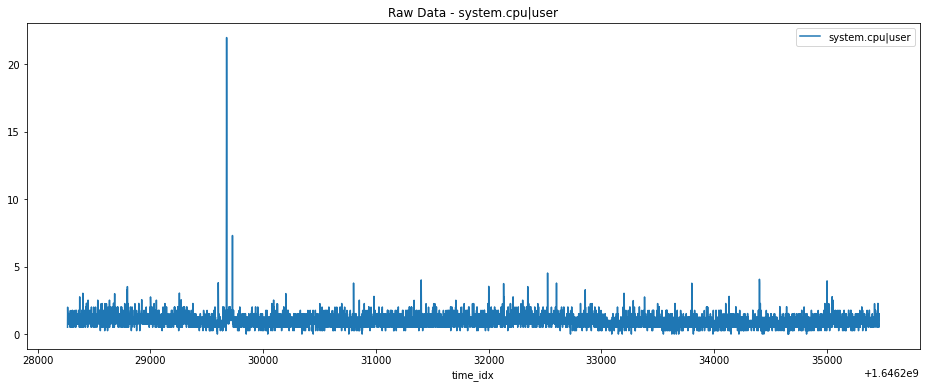

In [97]:
# get raw data
df = get_data(hosts=hosts, charts=charts, after=after, before=before)
if len(dims):
    df = df[[dim for dim in dims]]
print(df.shape)

# set some variables based on our data
df_timestamp_min = df.index.min()
df_timestamp_max = df.index.max()
print(df_timestamp_min, df_timestamp_max)

display(df.head())

# lets just plot each dimension
for col in df.columns:
    df.plot(title=f'Raw Data - {col}', figsize=(16,6))

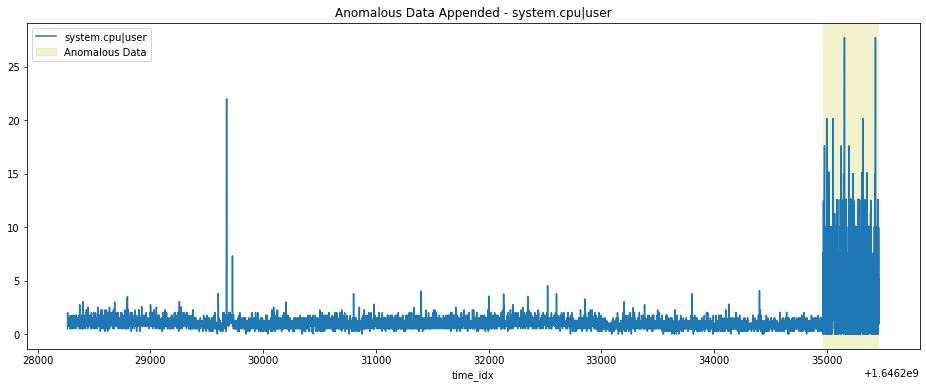

In [98]:
# size of anomalous data
n_tail = 500

# randomly scramble data and multiply randomly by some numbers to make it anomalous looking
data_anomalous = np.random.choice(df.tail(n_tail).values.reshape(-1,),(n_tail,len(df.columns))) * np.random.choice([0,1,5,10],(n_tail,len(df.columns)))

# create anomalous dataframe
df_anomalous = pd.DataFrame(data = data_anomalous, columns = df.columns)
df_anomalous.index = df.tail(n_tail).index

# overwrite last n_tail observations with anomalous data
df.update(df_anomalous)

# lets just plot each dimension now that we have added some anomalous data
for col in df.columns:
    ax = df.plot(title=f'Anomalous Data Appended - {col}', figsize=(16,6))
    add_shading_to_plot(ax, df_timestamp_max - n_tail, df_timestamp_max, 'Anomalous Data')

In [99]:
# initialize an empty kmeans model for each dimension
models = {
    dim: {
        'model' : KMeans(
            n_clusters=n_clusters_per_dimension, 
            max_iter=max_iterations
        ),
        'fitted': False
    }
    for dim in df.columns
}

# initialize dictionary for anomaly scores
anomaly_scores = {
    dim: {
        't' : [],
        'anomaly_score': []
    }
    for dim in df.columns
}

# initialize dictionary for anomaly bits
anomaly_bits = {
    dim: {
        't' : [],
        'anomaly_bit': []
    }
    for dim in df.columns
}

In [100]:
# loop over each row of data in df
for t, row in df.iterrows():

    # get n based on timestep
    n = t - df_timestamp_min

    # for each dim, if we have a fitted model then make predictions
    for dim in df.columns:

        # if we have a fitted model, get anomaly score
        if models[dim]['fitted']:

            # get recent data
            buffer_size = num_samples_to_diff + num_samples_to_smooth + num_samples_to_lag * 2
            df_dim_recent = df[[dim]].loc[(t-buffer_size):t]

            # preprocess/featurize recent data
            df_dim_recent_preprocessed = preprocess_df(
                df_dim_recent,
                num_samples_to_lag,
                num_samples_to_diff,
                num_samples_to_smooth
            )

            # take most recent feature vector
            X = df_dim_recent_preprocessed.tail(1).values

            # get anomaly score
            anomaly_score = np.sum(cdist(X, models[dim]['model'].cluster_centers_, metric='euclidean'), axis=1)[0]

            # normalize anomaly score
            anomaly_score = (anomaly_score - models[dim]['train_anomaly_score_min']) / (models[dim]['train_anomaly_score_max'] - models[dim]['train_anomaly_score_min'] )

            # get anomaly bit
            anomaly_bit = 100 if anomaly_score >= dimension_anomaly_score_threshold else 0
            
            # save anomaly score
            anomaly_scores[dim]['t'].append(t)
            anomaly_scores[dim]['anomaly_score'].append(anomaly_score)

            # save anomaly bit
            anomaly_bits[dim]['t'].append(t)
            anomaly_bits[dim]['anomaly_bit'].append(anomaly_bit)
    
    # check if need to train or retrain
    if (n >= num_samples_to_train) & (n % train_every == 0):

        train_before = t - num_samples_to_train
        train_after = t
        print(f'train at t={t}, (n={n}, train_after={train_after}, train_before={train_before})')

        # loop over each dimension/model
        for dim in df.columns:
            
            # get training data
            df_dim_train = df[[dim]].loc[(t-num_samples_to_train):t]
            
            # preprocess/featurize training data
            df_dim_train_preprocessed = preprocess_df(
                df_dim_train,
                num_samples_to_lag,
                num_samples_to_diff,
                num_samples_to_smooth
            )

            # fit model
            models[dim]['model'].fit(df_dim_train_preprocessed.values) 
            models[dim]['fitted'] = True

            # get training scores
            train_anomaly_scores = np.sum(cdist(df_dim_train_preprocessed.values, models[dim]['model'].cluster_centers_, metric='euclidean'), axis=1)
            # save min and max anomaly score during training, used to normalize all scores to be 0,1 scale
            models[dim]['train_anomaly_score_min'] = min(train_anomaly_scores)
            models[dim]['train_anomaly_score_max'] = max(train_anomaly_scores)


train at t=1646231865, (n=3600, train_after=1646231865, train_before=1646228265)


In [101]:
# create dataframe of anomaly scores
df_anomaly_scores = pd.DataFrame()
for dim in anomaly_scores:
    df_anomaly_scores_dim = pd.DataFrame(data=zip(anomaly_scores[dim]['t'],anomaly_scores[dim]['anomaly_score']),columns=['time_idx',f'{dim}__anomaly_score']).set_index('time_idx')
    df_anomaly_scores = df_anomaly_scores.join(df_anomaly_scores_dim, how='outer')

# create dataframe of anomaly bits
df_anomaly_bits = pd.DataFrame()
for dim in anomaly_bits:
    df_anomaly_bits_dim = pd.DataFrame(data=zip(anomaly_bits[dim]['t'],anomaly_bits[dim]['anomaly_bit']),columns=['time_idx',f'{dim}__anomaly_bit']).set_index('time_idx')
    df_anomaly_bits = df_anomaly_bits.join(df_anomaly_bits_dim, how='outer')

# join anomaly scores to raw df
df_final = df.join(df_anomaly_scores, how='outer')

# join anomaly bits to raw df
df_final = df_final.join(df_anomaly_bits, how='outer')

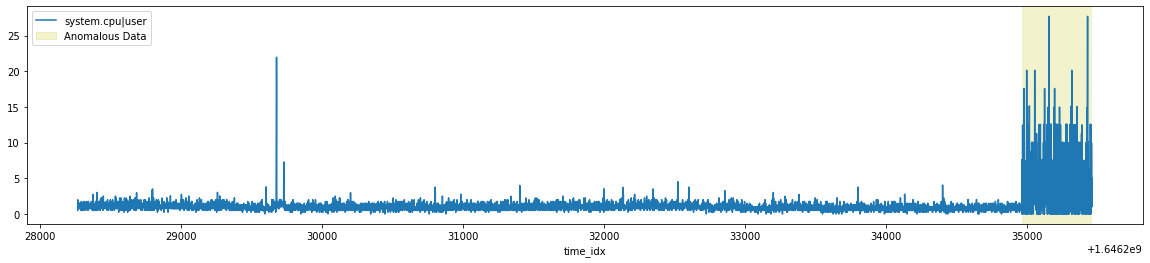

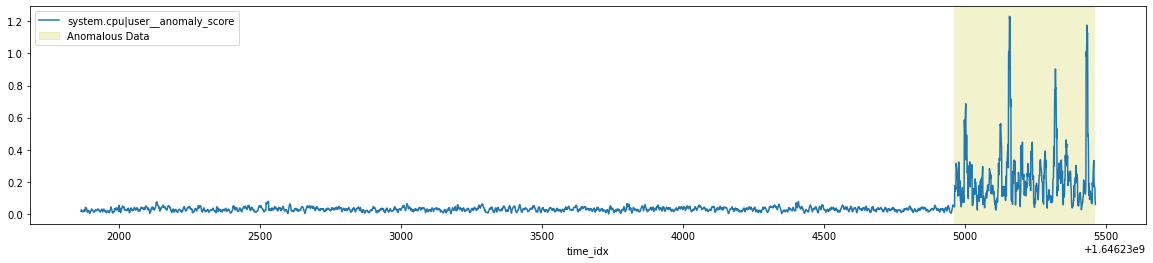

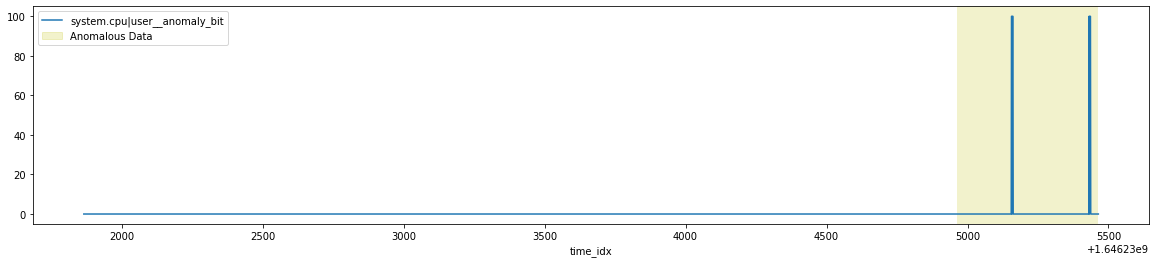

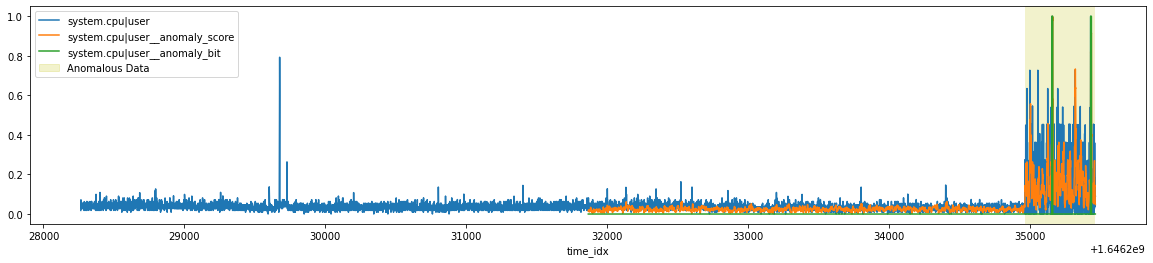

In [103]:
figsize = (20,4)

for dim in models:

    df_final_dim = df_final[[dim,f'{dim}__anomaly_score',f'{dim}__anomaly_bit']]
    ax = df_final_dim[[dim]].plot(figsize=figsize)
    add_shading_to_plot(ax, df_timestamp_max - n_tail, df_timestamp_max, 'Anomalous Data')
    
    ax = df_final_dim[[f'{dim}__anomaly_score']].plot(figsize=figsize)
    add_shading_to_plot(ax, df_timestamp_max - n_tail, df_timestamp_max, 'Anomalous Data')
    
    ax = df_final_dim[[f'{dim}__anomaly_bit']].plot(figsize=figsize)
    add_shading_to_plot(ax, df_timestamp_max - n_tail, df_timestamp_max, 'Anomalous Data')

    df_final_dim_normalized = (df_final_dim-df_final_dim.min())/(df_final_dim.max()-df_final_dim.min())
    ax = df_final_dim_normalized.plot(figsize=figsize)
    add_shading_to_plot(ax, df_timestamp_max - n_tail, df_timestamp_max, 'Anomalous Data')